In [1]:
import torch
import json
import numpy as np
import pickle
from tqdm import tqdm
from pathlib import Path

import matplotlib.pyplot as plt

from s4hci.utils.data_handling import load_adi_data
from s4hci.models.noise import S4Ridge

import torch.nn.functional as F
import torch.multiprocessing as mp

from s4hci.utils.masks import construct_round_rfrr_template, construct_rfrr_mask
from s4hci.utils.s4_rigde import compute_betas_least_square, compute_betas_svd

## Load the data

In [2]:
dataset_config_file = "../../../../70_results/x1_s4_cross_validation/0100_C-0656-A/dataset.json"

with open(dataset_config_file) as json_file:
    dataset_config = json.load(json_file)

print("Loading data ... ", end='')
science_data, raw_angles, raw_psf_template_data = \
    load_adi_data(dataset_config["file_path"],
                  data_tag=dataset_config["stack_key"],
                  psf_template_tag=dataset_config["psf_template_key"],
                  para_tag=dataset_config["parang_key"])

psf_template_data = np.mean(raw_psf_template_data, axis=0)

X_train = science_data[0::2]
X_test = science_data[1::2]
print("[DONE]")

Loading data ... [DONE]


## Data preparation

In [64]:
image_size = X_train.shape[1]

template_cut, _ = construct_round_rfrr_template(
    radius=4,
    psf_template_in=psf_template_data)

right_reason_mask = construct_rfrr_mask(
    template_setup=("radius", 4),
    psf_template_in=template_cut,
    mask_size_in=image_size)

In [65]:
print("Normalizing data ... ", end='')
mean_frame = np.mean(X_train, axis=0)
science_data = X_train - mean_frame

std_frame = np.std(science_data, axis=0)
science_data_norm = science_data / std_frame

template_norm = template_cut / np.max(np.abs(template_cut))

print("[DONE]")

Normalizing data ... [DONE]


## Test for LSTQR

In [66]:
half_precision = False
rank = 0
positions = [(20, 20), (40, 60), (30, 30), (60, 60)]
alpha = 10000

In [67]:
# get all the data we need as pytroch tensors
X_torch = torch.from_numpy(science_data_norm).unsqueeze(1)
p_torch = torch.from_numpy(template_norm).unsqueeze(0).unsqueeze(0)
M_torch = torch.from_numpy(right_reason_mask)

In [68]:
X_torch.shape

torch.Size([34666, 1, 107, 107])

In [69]:
beta_conv = compute_betas_least_square(
    X_torch=X_torch,
    p_torch=None,
    M_torch=M_torch,
    alpha=alpha,
    positions=positions,
    rank=rank,
    half_precision=False,
    verbose=True)

100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


In [70]:
beta_conv.shape

torch.Size([4, 107, 107])

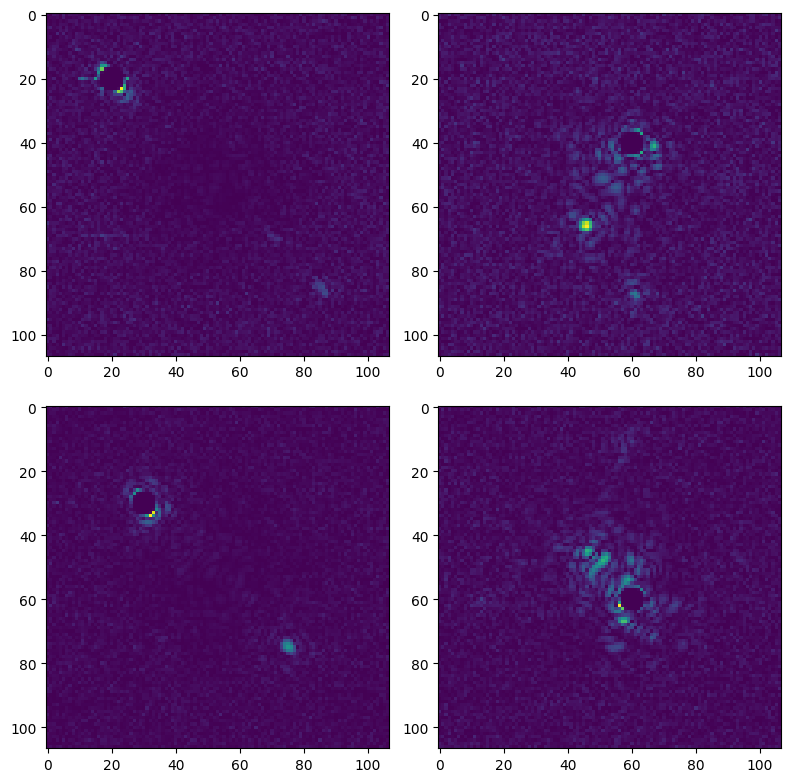

In [71]:
plt.figure(figsize=(8, 8))
ax1 = plt.subplot(2, 2, 1)
ax1.imshow(torch.abs(beta_conv)[0])

ax2 = plt.subplot(2, 2, 2)
ax2.imshow(torch.abs(beta_conv[1]))

ax2 = plt.subplot(2, 2, 3)
ax2.imshow(torch.abs(beta_conv[2]))

ax2 = plt.subplot(2, 2, 4)
ax2.imshow(torch.abs(beta_conv[3]))

plt.tight_layout()

## Test the SVD code

In [31]:
beta_conv = compute_betas_svd(
    X_torch=X_torch,
    p_torch=None,
    M_torch=M_torch,
    alphas=np.logspace(0, 6, 500),
    positions=positions,
    rank=rank,
    approx_svd=5000,
    half_precision=False,
    verbose=True)

100%|██████████| 4/4 [00:38<00:00,  9.50s/it]


In [32]:
beta_conv.shape

torch.Size([4, 500, 107, 107])

In [33]:
from matplotlib import rcParams
import ipywidgets
from ipywidgets import interact
import IPython

In [34]:
rcParams['figure.figsize'] = (15, 6)

def generate_plots_(alpha_idx, pos_idx):
    
    #alpha_idx = best_alphas_idx[pos_idx]
    sel_beta = beta_conv.cpu()[pos_idx, alpha_idx]
    alpha = np.logspace(0, 6, 500)[alpha_idx]
    
    fig, ax = plt.subplots(1, 1)
    
    ax.imshow(torch.abs(sel_beta))
    ax.set_title("Alpha = " + str(alpha))
    
    plt.show()

# set up the interaction tools
alpha_slider = ipywidgets.SelectionSlider(
    options=np.arange(500),
    value=0,
    description='Alpha:',
    disabled=False,
    orientation='horizontal',
    readout=True,
    readout_format='d')

pos_slider = ipywidgets.SelectionSlider(
    options=np.arange(4),
    value=0,
    description='Position:',
    disabled=False,
    orientation='horizontal',
    readout=True,
    readout_format='d')

interact(
    generate_plots_,
    alpha_idx=alpha_slider,
    pos_idx=pos_slider,
);

interactive(children=(SelectionSlider(description='Alpha:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,…

## Implement finding alpha with SVD

In [72]:
alphas = np.logspace(1, 8, 500)

In [73]:
step_size = 10
test_positions = [(y, x)
                  for x in range(0, image_size, step_size)
                  for y in range(0, image_size, step_size)]

In [74]:
step_size = 4
test_positions = [(y, 53)
                  for y in range(0, image_size, step_size)]

In [75]:
# replace with multiprocessing later
beta_conv = compute_betas_svd(
    X_torch=X_torch,
    p_torch=None,
    M_torch=M_torch,
    alphas=alphas,
    positions=test_positions,
    rank=rank,
    approx_svd=5000,
    half_precision=False,
    verbose=True)

100%|██████████| 27/27 [04:18<00:00,  9.56s/it]


In [76]:
beta_conv.shape

torch.Size([27, 500, 107, 107])

In [77]:
# 3.) prepare the test data for pytorch
# Normalize the test data
X_test_norm = X_test - mean_frame
X_test_norm = X_test_norm / std_frame

In [78]:
X_test_torch = torch.from_numpy(X_test_norm)
X_test_torch = X_test_torch.flatten(start_dim=1)
if half_precision:
    X_test_torch = X_test_torch.float()

In [79]:
X_test_torch = X_test_torch.to(rank)
beta_conv = beta_conv.to(rank)

In [80]:
idx_positions = [x * image_size + y for x, y in test_positions]

In [81]:
errors = []
for i in tqdm(range(500)):
    tmp_betas = beta_conv[:,i, :, :].flatten(start_dim=1)
    
    # 4.) make the prediction
    Y_test = X_test_torch @ tmp_betas.T
    abs_errors = torch.abs(Y_test - X_test_torch[:, idx_positions])
    tmp_errors = np.mean(abs_errors.cpu().numpy(), axis=0)
    errors.append(tmp_errors)

100%|██████████| 500/500 [00:02<00:00, 235.50it/s]


In [82]:
final_errors = np.stack(errors)

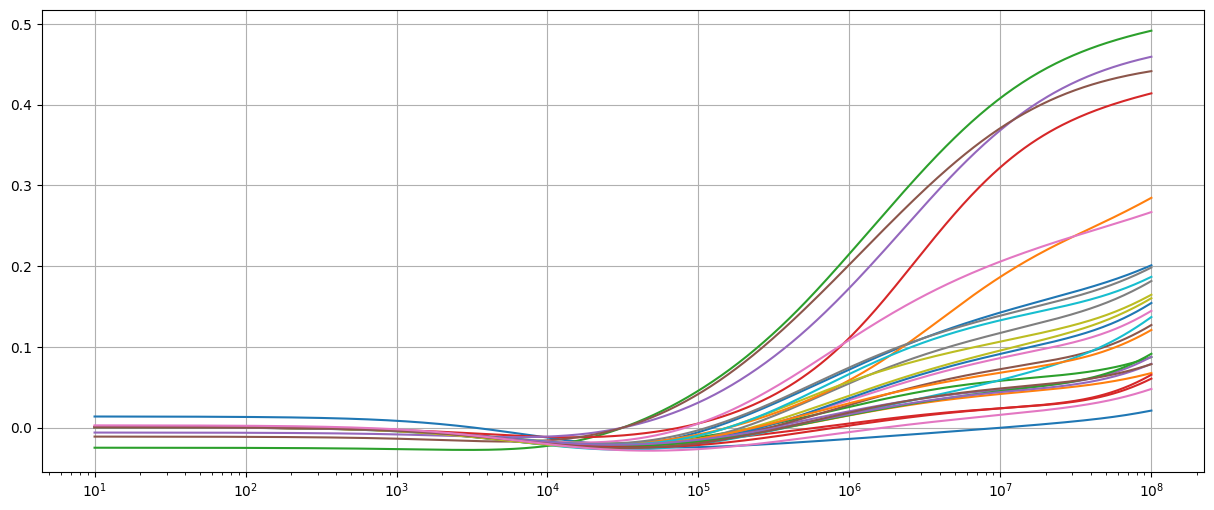

In [83]:
plt.plot(alphas, final_errors - np.median(final_errors, axis=0))
plt.grid()
plt.xscale("log")

In [84]:
avg_errors = np.mean(final_errors - np.median(final_errors, axis=0), axis=1)

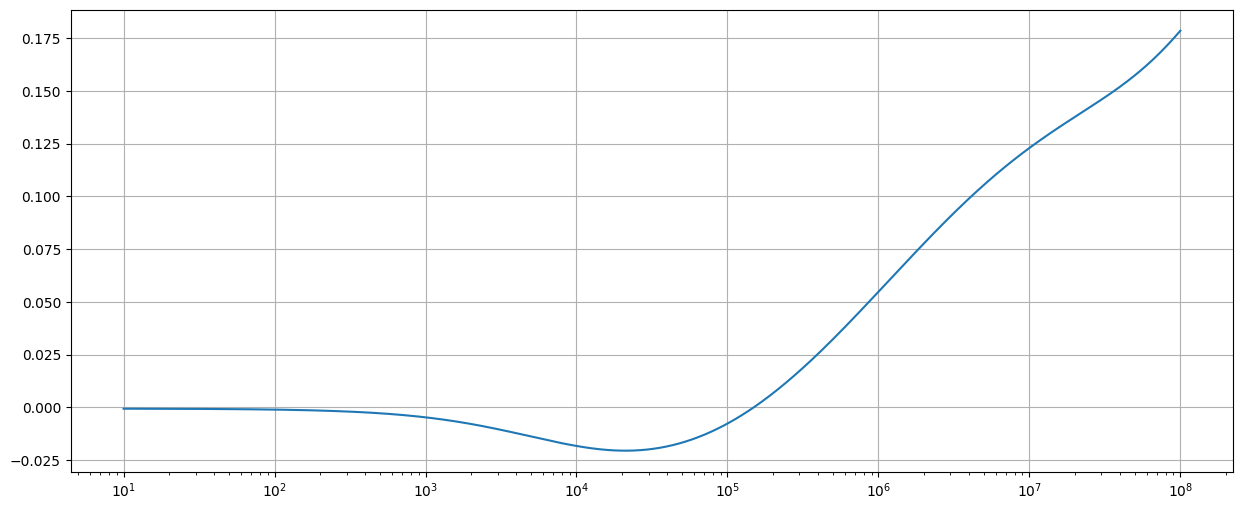

In [85]:
plt.plot(alphas, np.mean(final_errors - np.median(final_errors, axis=0), axis=1))
plt.grid()
plt.xscale("log")

In [86]:
alphas[np.argmin(avg_errors)]

21117.83044448242

## Check 2D trends

In [87]:
best_alphas_idx = np.argmin(final_errors - np.median(final_errors, axis=0), axis=0)
best_alphas = alphas[best_alphas_idx]

In [88]:
best_alphas_idx

array([274, 246, 242, 246, 245, 248, 245, 248, 244, 249, 237, 239, 176,
       225, 199, 195, 230, 236, 239, 243, 249, 243, 247, 255, 245, 251,
       262])

<function matplotlib.pyplot.grid(visible=None, which='major', axis='both', **kwargs)>

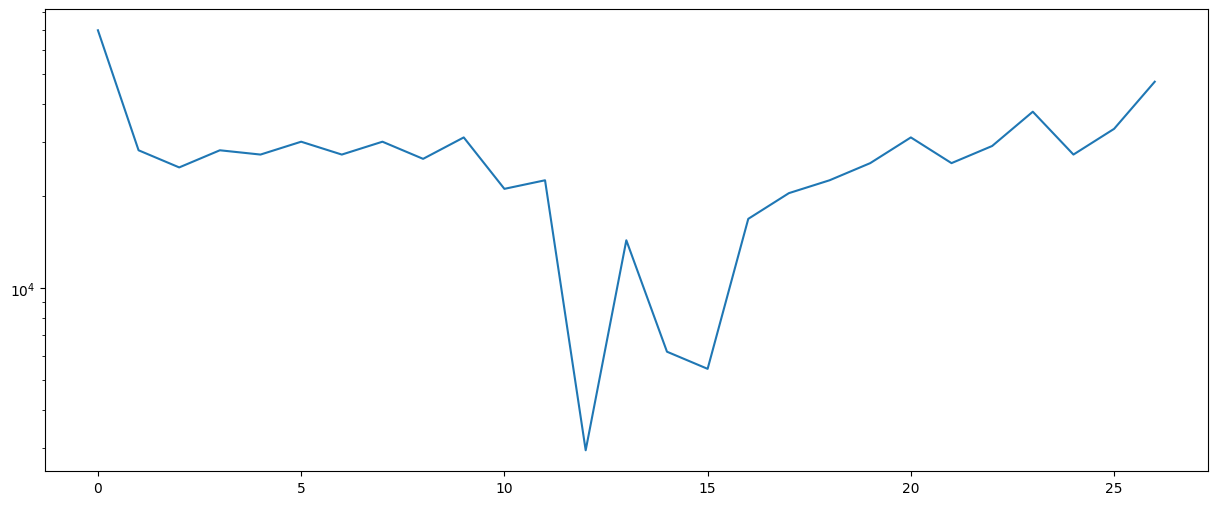

In [89]:
plt.plot(best_alphas)
plt.yscale("log")
plt.grid

In [91]:
rcParams['figure.figsize'] = (15, 6)

def generate_plots_(pos_idx):
    
    alpha_idx = best_alphas_idx[pos_idx]
    sel_beta = beta_conv.cpu()[pos_idx, alpha_idx]
    alpha = alphas[alpha_idx]
    
    fig, ax = plt.subplots(1, 1)
    
    ax.imshow(torch.abs(sel_beta))
    ax.set_title("Alpha = " + str(alpha))
    
    plt.show()

# set up the interaction tools
pos_slider = ipywidgets.SelectionSlider(
    options=np.arange(27),
    value=0,
    description='Position:',
    disabled=False,
    orientation='horizontal',
    readout=True,
    readout_format='d')

interact(
    generate_plots_,
    pos_idx=pos_slider,
);

interactive(children=(SelectionSlider(description='Position:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, …